In [1]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import (SegformerImageProcessor, 
                          AutoModelForSemanticSegmentation,
                          Trainer, TrainingArguments,
                          TrainerCallback)
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import evaluate
from tqdm import tqdm
import os
import wandb
wandb.init(mode="disabled")
os.environ["WANDB_DISABLED"] = "true"

/home/jorge/anaconda3/envs/ARF/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class HFiMaterialistDataset(Dataset):
    
    def __init__(self, hf_dataset, processor, is_test=True):
        """
        hf_dataset: A Hugging Face Dataset (not DatasetDict)
        processor: A SegformerImageProcessor instance
        """
        self.dataset = hf_dataset
        self.processor = processor
        self.is_test = is_test

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        mask = item["mask"]

        if self.is_test:
            encoding = self.processor(
                images=image,
                return_tensors='pt'
            )
        else:
            encoding = self.processor(
                images=image,
                segmentation_maps=mask,
                return_tensors='pt'
            )

        for k in encoding:
            encoding[k] = encoding[k].squeeze(0)

        if self.is_test:
            encoding["image"] = image
        return encoding

In [3]:
hf_dataset = load_dataset("sergiomadrid/imaterialist")
model_name = "nvidia/mit-b0"
processor = SegformerImageProcessor.from_pretrained(model_name, do_reduce_labels=True)

/home/jorge/anaconda3/envs/ARF/lib/python3.13/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [4]:
val_ratio = 0.001
val_size = int(val_ratio * len(hf_dataset["train"]))
train_size = len(hf_dataset["train"]) - val_size
hf_train, hf_val = random_split(hf_dataset["train"], [train_size, val_size])
hf_test = hf_dataset['test']

# Select number of samples from each split
#hf_train = torch.utils.data.Subset(hf_train, range(100))
#hf_val = torch.utils.data.Subset(hf_val, range(50))
#hf_test = torch.utils.data.Subset(hf_test, range(50))

train_dataset = HFiMaterialistDataset(hf_train, processor, is_test=False)
val_dataset = HFiMaterialistDataset(hf_val, processor, is_test=False)
test_dataset = HFiMaterialistDataset(hf_test, processor, is_test=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 45578
Validation dataset size: 45
Test dataset size: 3200


In [5]:
print(train_dataset[0].keys())
print(train_dataset[0]['pixel_values'].shape)

dict_keys(['pixel_values', 'labels'])
torch.Size([3, 512, 512])


In [6]:
print(train_dataset[0]['labels'])

tensor([[255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        ...,
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]])


In [7]:
url = "https://huggingface.co/datasets/sergiomadrid/imaterialist/resolve/main/label_descriptions.json"
label_json = requests.get(url).json()

categories = label_json["categories"]

id2label = {cat["id"]: cat["name"] for cat in categories}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

# Check
print("Number of classes:", num_labels)
print(id2label)

Number of classes: 46
{0: 'shirt, blouse', 1: 'top, t-shirt, sweatshirt', 2: 'sweater', 3: 'cardigan', 4: 'jacket', 5: 'vest', 6: 'pants', 7: 'shorts', 8: 'skirt', 9: 'coat', 10: 'dress', 11: 'jumpsuit', 12: 'cape', 13: 'glasses', 14: 'hat', 15: 'headband, head covering, hair accessory', 16: 'tie', 17: 'glove', 18: 'watch', 19: 'belt', 20: 'leg warmer', 21: 'tights, stockings', 22: 'sock', 23: 'shoe', 24: 'bag, wallet', 25: 'scarf', 26: 'umbrella', 27: 'hood', 28: 'collar', 29: 'lapel', 30: 'epaulette', 31: 'sleeve', 32: 'pocket', 33: 'neckline', 34: 'buckle', 35: 'zipper', 36: 'applique', 37: 'bead', 38: 'bow', 39: 'flower', 40: 'fringe', 41: 'ribbon', 42: 'rivet', 43: 'ruffle', 44: 'sequin', 45: 'tassel'}


In [8]:
model = AutoModelForSemanticSegmentation.from_pretrained(
            model_name,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id,
        )

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [9]:
metric = evaluate.load("mean_iou")

def compute_metrics(eval_preds):
    with torch.no_grad():
        logits, labels = eval_preds
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        return {
            "mean_iou": metrics["mean_iou"],
            "mean_acc": metrics["mean_accuracy"]
        }

In [10]:
batch_size = 2

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=2,
    learning_rate=1e-4,
    bf16=True,
    bf16_full_eval=True,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    #load_best_model_at_end=True,
    metric_for_best_model="mean_iou",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [11]:
class MyTrainer(Trainer):
    def log(self, logs, *args, **kwargs):
        logs["learning_rate"] = self._get_learning_rate()
        super().log(logs)

In [12]:
trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    #tokenizer=processor,
)

In [13]:
trainer.train()
trainer.save_model("./segfomer_imaterialist")

Epoch,Training Loss,Validation Loss,Mean Iou,Mean Acc,Rate
1,1.009700,0.998203,0.252643,0.326174,0.000068
2,0.760600,0.904188,0.293205,0.371734,0.000000


/home/jorge/anaconda3/envs/ARF/lib/python3.13/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/home/jorge/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/jorge/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/home/jorge/anaconda3/envs/ARF/lib/python3.13/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warni

In [14]:
model = AutoModelForSemanticSegmentation.from_pretrained(
    "./segfomer_imaterialist",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

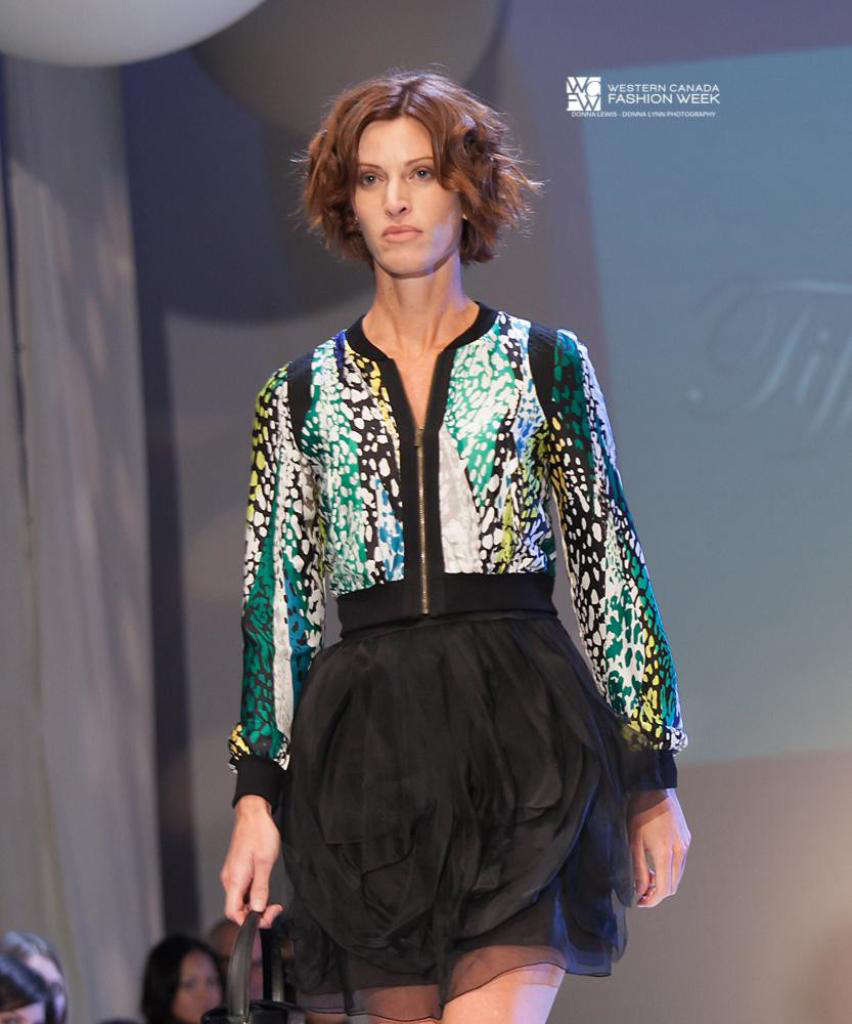

In [15]:
image = test_dataset[0]['image']
display(image)

In [16]:
pixel_values = test_dataset[0]["pixel_values"].unsqueeze(0).to("cuda")
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [17]:
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)

In [18]:
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 46, 128, 128])


(1024, 852)
[[ 5  5  5 ...  0  0  0]
 [ 5  5  5 ...  0  0  0]
 [ 5  5  5 ...  0  0  0]
 ...
 [22 22 22 ...  0  0  0]
 [22 22 22 ...  0  0  0]
 [22 22 22 ...  0  0  0]]
[[ 5  5  5 ...  0  0  0]
 [ 5  5  5 ...  0  0  0]
 [ 5  5  5 ...  0  0  0]
 ...
 [22 22 22 ...  0  0  0]
 [22 22 22 ...  0  0  0]
 [22 22 22 ...  0  0  0]]


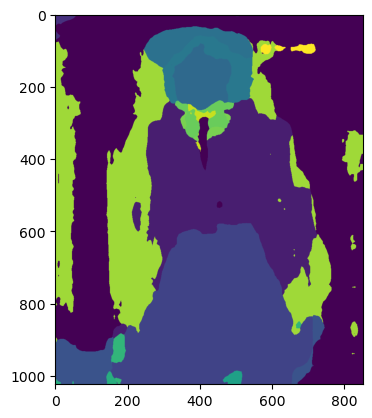

In [19]:
pred_seg_map = processor.post_process_semantic_segmentation(
            outputs=outputs,
            target_sizes=[image.size[::-1]]
    )[0]
pred_seg_map = pred_seg_map.cpu().numpy()
print(pred_seg_map.shape)
print(pred_seg_map)
plt.imshow(pred_seg_map)
print(pred_seg_map)

In [20]:
model = AutoModelForSemanticSegmentation.from_pretrained("./segfomer_imaterialist")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

all_preds = []
for i in tqdm(range(len(test_dataset)), desc="Running inference"):
    inputs = torch.tensor(test_dataset[i]["pixel_values"]).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
    all_preds.append(preds.squeeze(0).cpu().numpy())

Running inference:   0%|          | 0/3200 [00:00<?, ?it/s]/tmp/ipykernel_149076/1463721915.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(test_dataset[i]["pixel_values"]).unsqueeze(0).to(device)
Running inference: 100%|██████████| 3200/3200 [01:17<00:00, 41.06it/s]


In [21]:
print(all_preds[0].shape)

(128, 128)


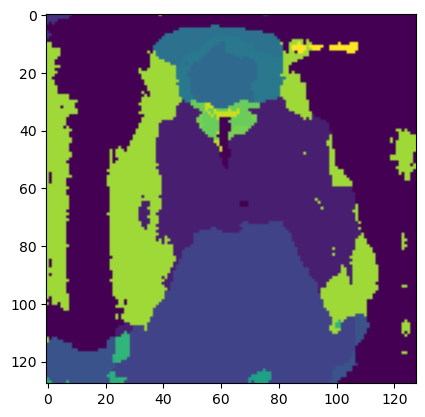

In [22]:
plt.imshow(all_preds[0])